# 一、抄袭文本自动判定¶

#### 1.问题转换  
  #### ——定义抄袭文本  
#### 2.数据描述  
#### 3.数据预处理  
#### 4.多模型分类  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer   #与第四的差别？
import jieba
import re
import time

In [2]:
PATH = r'D:\NLP'
content = pd.read_csv(PATH+r'\sqlResult_1558435.csv',encoding='gb18030')

In [3]:
content.head()

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...


In [4]:
xinhua_news = content[content.source == '新华社']

In [5]:
len(xinhua_news)/len(content) #新华社新闻在总新闻所占的长度？

0.8778051801676133

In [6]:
news = pd.DataFrame(content)
news['y']=np.where(news.source == '新华社',0,1)    #这一步是干什么的，新华社标0，其他标1吗
print(len(news[news.y==1])/len(news))

0.12219481983238666


In [7]:
news.head(5)

,id,author,source,content,feature,title,url,y
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm,1
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm,1
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm,1
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....,0
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...,1


# 二、数据预处理

#### 1.提取content字段新闻数据  
#### 2.分词  
#### 3.tfidf特征提取

In [8]:
#pattern1 = re.compile(r'\n')
pattern1 = re.compile("[\s+\.\!?\/_,$`%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）“”：；【】]+")  #去除标点

In [9]:
def clearing(string,pattern):
    return re.sub(pattern,'',string).replace('\n','')

In [10]:
content_cleaned = [clearing(str(content),pattern1) for content in news.content]  #????

In [14]:
#content_cleaned[:10]

['此外自本周6月12日起除小米手机6等15款机型外其余机型已暂停更新发布含开发版体验版内测稳定版暂不受影响以确保工程师可以集中全部精力进行系统优化工作有人猜测这也是将精力主要用到MIUI9的研发之中MIUI8去年5月发布距今已有一年有余也是时候更新换代了当然关于MIUI9的确切信息我们还是等待官方消息',
 '骁龙835作为唯一通过Windows10桌面平台认证的ARM处理器高通强调不会因为只考虑性能而去屏蔽掉小核心相反他们正联手微软找到一种适合桌面平台的兼顾性能和功耗的完美方案报道称微软已经拿到了一些新的源码以便Windows10更好地理解biglittle架构资料显示骁龙835作为一款集成了CPUGPU基带蓝牙Wi-Fi的SoC比传统的Wintel方案可以节省至少30的PCB空间按计划今年Q4华硕惠普联想将首发骁龙835Win10电脑预计均是二合一形态的产品当然高通骁龙只是个开始未来也许还能见到三星Exynos联发科华为麒麟小米澎湃等进入Windows10桌面平台',
 '此前的一加3T搭载的是3400mAh电池DashCharge快充规格为5V4A至于电池缩水可能与刘作虎所说一加手机5要做市面最轻薄大屏旗舰的设定有关按照目前掌握的资料一加手机5拥有55寸1080P三星AMOLED显示屏6G8GBRAM64GB128GBROM双1600万摄像头备货量惊喜根据京东泄露的信息一加5起售价是xx99元应该是在279928992999中的某个',
 '这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车新华社记者张立云摄',
 '原标题44岁女子跑深圳约会网友被拒暴雨中裸身奔走深圳交警微博称昨日清晨交警发现有一女子赤裸上身行走在南坪快速上期间还起了轻生年头一辅警发现后赶紧为其披上黄衣并一路劝说她那么事发时到底都发生了些什么呢南都记者带您一起还原现场南都记者在龙岗大队坂田中队见到了辅警刘青发现女生的辅警一位外表高大帅气说话略带些腼腆的90后青年刘青介绍6月16日早上7时36分他正在环城南路附近值勤接到中队关于一位女子裸身进入机动车可能有危险的警情随后骑着小铁骑开始沿路寻找大概花了十多分钟在南坪大道坂田出口往龙岗方向的逆行辅道上发现该女子女子身上一丝不挂地逆车流而行时走时停时坐时躺险象环生刘青停好小铁骑和另外一名巡防员追了上去发现女子的情绪很低落话不多刘青尝

In [11]:
%%time
content_cutted = [' '.join(jieba.cut(s)) for s in content_cleaned] #分词，耗时较长，耗时3min 

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Geoffrey\AppData\Local\Temp\jieba.cache
Loading model cost 0.743 seconds.
Prefix dict has been built succesfully.


Wall time: 2min 16s


In [12]:
content_cutted[:10]
#查看1-10的切词内容

NameError: name 'content_cutted' is not defined

In [33]:
tfidf_vectorizer = TfidfVectorizer(encoding='gb18030',use_idf=True)
tfidf_vectors = tfidf_vectorizer.fit_transform(content_cutted)

NameError: name 'content_cutted' is not defined

## 来自第二位同学的作业  新闻抄袭判别

https://github.com/Brycexxx/NLP-Assignment/blob/master/Lesson-07/Assignment-07.ipynb

In [4]:
import jieba
import re
from tqdm import tqdm  #tqdm 是 Python 进度条库,可以在 Python 长循环中添加一个进度提示信息用法
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

%matplotlib notebook

In [ ]:
## 数据预处理

In [5]:
news = pd.read_csv('D:/NLP/sqlResult_1558435.csv', encoding='gb18030')

In [6]:
news.head(3)

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm


In [7]:
len(news)

89611

In [8]:
news_dropna = news.dropna(subset=['source', 'content'])  #可以通过subset参数来删除在source和content中含有空数据的全部行
len(news_dropna)

87052

In [9]:
def transform(line):
    class_ = 1 if line['source'] == '新华社' else 0
    return pd.Series([class_, line['content']], index=['y', 'content'])

In [10]:
data = news_dropna.apply(transform, axis=1)  #apply 在使用 axis 时，默认 axis=1 表示按行计算,有NaN就去除此行

In [11]:

data.head()

,y,content
0,0,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...
1,0,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...
2,0,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...
3,1,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n
4,0,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...


In [12]:
corpus = data.content.to_list() ###？？？？
y = data.y.values.astype(np.int)  ###？？？？？？？？？

In [13]:
y.shape

(87052,)

In [14]:
len(corpus)

87052

## 使用 tfidf 进行文本向量化

In [29]:
corpus_cut = []
mask = []   #???
for sentence in tqdm(corpus):
    if not isinstance(sentence, str):
        mask.append(False)
        continue
    mask.append(True)
    sentence = ''.join(re.findall(r'\w+', sentence))
    corpus_cut.append(' '.join(jieba.cut(sentence)))
len(corpus_cut)

100%|███████████████████████████████████████████████████████████████████████████| 87052/87052 [02:25<00:00, 598.37it/s]


87052

In [ ]:
### 上面文本向量化到底是什么意思，不太明

In [30]:
y = y[mask]
len(y)

87052

In [32]:
corpus_cut[0]

'此外 自 本周 6 月 12 日起 除 小米 手机 6 等 15 款 机型 外 其余 机型 已 暂停 更新 发布 含 开发 版 体验版 内测 稳定版 暂不受 影响 以 确保 工程师 可以 集中 全部 精力 进行 系统优化 工作 有人 猜测 这 也 是 将 精力 主要 用到 MIUI9 的 研发 之中 MIUI8 去年 5 月 发布 距今已有 一年 有余 也 是 时候 更新换代 了 当然 关于 MIUI9 的 确切 信息 我们 还是 等待 官方消息'

In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=300) #为什么选择300，选择400可以不？max_features ???????
X = vectorizer.fit_transform(corpus_cut)

In [34]:
X = X.toarray()
X.shape

(87052, 300)

## 建模

In [35]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

#ROC（Receiver Operating Characteristic）曲线和AUC常被用来评价一个二值分类器（binary classifier）的优劣。

In [36]:
random_state = 2019 #？为什么是2019

In [37]:
X_train, x_test, Y_train, y_test = train_test_split(X,y,random_state=random_state,test_size=0.15)

In [38]:
X_train.shape,x_test.shape

((73994, 300), (13058, 300))

## KNN
KNeighborsClassifier, k=5(初始设置)

In [41]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, random_state=42, test_size=0.15)

In [42]:
x_train.shape, x_valid.shape

((62894, 300), (11100, 300))

In [43]:
knc = KNeighborsClassifier(n_jobs=-1) #为什么是-1
knc.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [44]:
knc.score(x_valid, y_valid)

0.9175675675675675

In [46]:
y_pred = knc.predict(x_valid)
y_pred_prob = knc.predict_proba(x_valid)

In [47]:
y_pred.shape, y_pred_prob.shape

((11100,), (11100, 2))

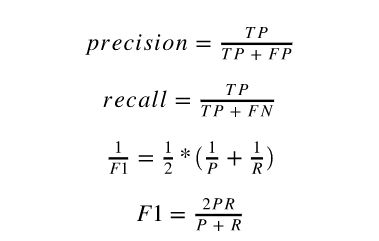

In [48]:
precision_score(y_valid, y_pred)

0.9552164372631159

In [49]:
recall_score(y_valid, y_pred)

0.9535995220551629

In [50]:
f1_score(y_valid, y_pred)

0.9544072948328267

In [51]:
roc_auc_score(y_valid,y_pred_prob[:,1])

0.9008588518754408

**调整参数， k=3** 怎么知道设置5,3是随机设置的吗

In [52]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, random_state=62, test_size=0.15)

In [53]:
knc = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knc.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [54]:
y_pred = knc.predict(x_valid)
y_pred_prob = knc.predict_proba(x_valid)

In [55]:
knc.score(x_valid, y_valid)

0.9307207207207208

In [56]:
precision_score(y_valid, y_pred)

0.9542907696844589

In [57]:
recall_score(y_valid, y_pred)

0.9696364362764682

In [58]:
f1_score(y_valid, y_pred)

0.9619024027743374

In [59]:
roc_auc_score(y_valid, y_pred_prob[:, 1])

0.8839187552143312

**recall 都提高了，precision roc 却降低了**

**调整参数 k=7**

In [60]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, random_state=62, test_size=0.15)

In [61]:
knc = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
knc.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='uniform')

In [62]:
y_pred = knc.predict(x_valid)
y_pred_prob = knc.predict_proba(x_valid)

In [63]:
y_pred.shape, y_pred_prob.shape

((11100,), (11100, 2))

In [64]:
knc.score(x_valid, y_valid)

0.9181981981981981

In [65]:
precision_score(y_valid, y_pred)

0.9538384845463609

In [66]:
recall_score(y_valid, y_pred)

0.9555533359968038

In [67]:
f1_score(y_valid, y_pred)

0.9546951402055682

In [68]:
roc_auc_score(y_valid, y_pred_prob[:, 1])

0.9183032750405395

In [ ]:
**使用距离作为权重？？**

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, random_state=72, test_size=0.15)

In [ ]:
knc = KNeighborsClassifier(n_neighbors=7, n_jobs=-1, weights='distance')
knc.fit(x_train, y_train)

In [ ]:
y_pred = knc.predict(x_valid)
y_pred_prob = knc.predict_proba(x_valid)

In [ ]:
y_pred.shape, y_pred_prob.shape

In [ ]:
knc.score(x_valid, y_valid)

In [ ]:
precision_score(y_valid, y_pred)

In [ ]:
recall_score(y_valid, y_pred)

In [ ]:
f1_score(y_valid, y_pred)

In [ ]:
roc_auc_score(y_valid, y_pred_prob[:, 1])

In [ ]:
**尝试提高 leaf-size**

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, random_state=92, test_size=0.15)

In [ ]:
knc = KNeighborsClassifier(n_neighbors=7, n_jobs=-1, weights='distance', leaf_size=50)
knc.fit(x_train, y_train)

In [ ]:
y_pred = knc.predict(x_valid)
y_pred_prob = knc.predict_proba(x_valid)

In [ ]:
knc.score(x_valid, y_valid)

In [ ]:
precision_score(y_valid, y_pred)

In [ ]:
recall_score(y_valid, y_pred)

In [ ]:
f1_score(y_valid, y_pred)

In [ ]:
roc_auc_score(y_valid, y_pred_prob[:, 1])

In [ ]:
**继续增加 leaf-size**

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, random_state=92, test_size=0.15)

In [ ]:
knc = KNeighborsClassifier(n_neighbors=7, n_jobs=-1, weights='distance', leaf_size=70)
knc.fit(x_train, y_train)

In [ ]:
y_pred = knc.predict(x_valid)
y_pred_prob = knc.predict_proba(x_valid)

In [ ]:
knc.score(x_valid, y_valid)

In [ ]:
precision_score(y_valid, y_pred)

In [ ]:
recall_score(y_valid, y_pred)

In [ ]:
f1_score(y_valid, y_pred)

In [ ]:
roc_auc_score(y_valid, y_pred_prob[:, 1])

In [ ]:
**使用 grid-search 确定超参数**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'n_neighbors': [3, 5, 7], 'leaf_size': [30, 45, 60]}

In [ ]:
knc = KNeighborsClassifier(n_jobs=5, weights='distance')

In [ ]:
clf = GridSearchCV(knc, parameters, cv=5, scoring='roc_auc', verbose=5, n_jobs=5)
clf

In [ ]:
clf.fit(X_train, Y_train)

In [ ]:
***时间非常长，卡得很，选择放弃*

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, random_state=92, test_size=0.15)

In [ ]:
knc = KNeighborsClassifier(n_neighbors=7, n_jobs=-1, weights='distance', leaf_size=40) 
knc.fit(x_train, y_train)

In [ ]:
y_pred = knc.predict(x_valid) 
y_pred_prob = knc.predict_proba(x_valid)

In [ ]:
knc.score(x_valid, y_valid)

In [ ]:
precision_score(y_valid, y_pred)

In [ ]:
recall_score(y_valid, y_pred)

In [ ]:
f1_score(y_valid, y_pred)

In [ ]:
roc_auc_score(y_valid, y_pred_prob[:, 1])

**针对 KNN 最佳参数暂时确定为 $n\_neighbors=7, weights='distance',leaf\_size=40$**

## Naive Bayes

In [69]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, random_state=1002, test_size=0.15)

In [70]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [71]:
y_pred = gnb.predict(x_valid) 
y_pred_prob = gnb.predict_proba(x_valid)

In [72]:
gnb.score(x_valid,y_valid)

0.807027027027027

In [73]:
precision_score(y_valid,y_pred)

0.9981153411232567

In [74]:
recall_score(y_valid,y_pred)

0.7887995233839737

In [75]:
f1_score(y_valid,y_pred)

0.8811980033277869

In [76]:
roc_auc_score(y_valid,y_pred_prob[:,1])

0.9410166438307452

**贝叶斯好像没啥好调的……训练速度很快比 KNN 快多了，recall低， roc更高**

## Logistic Regression

In [77]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, random_state=1002, test_size=0.15)

In [78]:
lr = LogisticRegression(n_jobs=-1) # 先来个 baseline
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
lr.score(x_valid,y_valid)

0.9807207207207207

In [80]:
y_pred = lr.predict(x_valid)
y_pred_prob = lr.predict_proba(x_valid)

In [81]:
precision_score(y_valid,y_pred)

0.9876323340259227

In [82]:
recall_score(y_valid,y_pred)

0.9911627445139509

In [83]:
f1_score(y_valid,y_pred)

0.9893943899296264

In [84]:
roc_auc_score(y_valid, y_pred_prob[:, 1])

0.9937303744000685

**lr的效果很棒，感觉都不需要调……**

## 利用 test set 选定模型

In [ ]:
**KNN**

In [86]:
knc.score(x_test, y_test)

0.9192066166334814

In [88]:
y_pred = knc.predict(x_test)
y_pred_prob = knc.predict_proba(x_test)

In [89]:
precision_score(y_test,y_pred)

0.9540812019920655

In [90]:
recall_score(y_test,y_pred)

0.9567462332825462

In [91]:
f1_score(y_test,y_pred)

0.9554118591775496

In [92]:
roc_auc_score(y_test,y_pred_prob[:, 1])

0.911179825342106

**Gaussian Naive Bayes**

In [95]:
gnb.score(x_test,y_test)

0.79621687854189

In [97]:
y_pred = gnb.predict(x_test)
y_pred_prob = gnb.predict_proba(x_test)

In [98]:
precision_score(y_test,y_pred)

0.9984751116436118

In [99]:
recall_score(y_test,y_pred)

0.7759437954968681

In [100]:
f1_score(y_test,y_pred)

0.8732555370326268

In [ ]:
roc_auc_score(y_test, y_pred_prob[:, 1])

**Logistic Regression**

In [101]:
lr.score(x_test,y_test)

0.9790932761525502

In [102]:
y_pred = lr.predict(x_test)
y_pred_prob = lr.predict_proba(x_test)

In [103]:
precision_score(y_test, y_pred)

0.9856914401144685

In [104]:
recall_score(y_test, y_pred)

0.9912815303876756

In [105]:
f1_score(y_test, y_pred)

0.9884785819793206

In [106]:
roc_auc_score(y_test, y_pred_prob[:, 1])

0.9906651640078233

逻辑回归即使在未见过的测试集上表现依然很好，最后选定逻辑回归模型

性能达到某个点可以定义为：在这个点训练集误差依然减小而验证集的误差不再下降反而开始上升也就是模型开始过拟合了

## 找出所以预测为 1， 但是实际为 0 的文章。 作为抄袭的候选者

In [107]:
# 对所有的 x 进行预测
y_pred = lr.predict(X)
y_pred.shape, y.shape

((87052,), (87052,))

In [108]:
len(news_dropna)

87052

In [109]:
news_dropna.head(3)

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm


In [110]:
news_dropna['y'] = y
news_dropna['y_pred'] = y_pred
news_dropna.head(2)

,id,author,source,content,feature,title,url,y,y_pred
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm,0,0
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm,0,0


In [111]:
# 实际为 0 ，预测为 1
copy_news = news_dropna[(news_dropna.y == 0) & (news_dropna.y_pred == 1)]
copy_news.head(2)

,id,author,source,content,feature,title,url,y,y_pred
51,89566,NaN,新华网,戈壁的大漠黄沙曾掩埋了无数西域古道，而如今一条大漠天路正顽强地与黄沙“搏斗”，在乌兰布和、腾...,"{""type"":""国内新闻"",""site"":""环球"",""commentNum"":""0"",""j...",大漠变通途——世界上最长的穿越沙漠高速公路建设纪实,http://china.huanqiu.com/hot/2017-06/10866392....,0,1
56,89561,NaN,央视新闻,很快，不少人主动添加记者为好友，询问是否需要扫描软件，并声称这些扫描软件能够攻破摄像头的IP...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",大量家庭摄像头遭入侵 有人兜售IP地址给偷窥者,http://www.cnbeta.com/articles/tech/623631.htm,0,1


In [112]:
len(copy_news.source)

1106

In [113]:
copy_sources = set(copy_news.source.to_list())

In [114]:
len(copy_sources)

276

## 使用第4课讲解的 edit distance，在涉嫌抄袭的文章中，找到其重复的文字与被修改过的文字。

In [116]:
def edit_distance(string1, string2):
    """string1 => string2"""
    len1, len2 = len(string1), len(string2)
    if len1 == 0 and len2 == 0: return 0
    if len2 == 0: return len1, []
    if len1 == 0: return len2, []
    dp = [[0] * (len2+1) for _ in range(len1+1)]
    duplication = []
    for i in range(1, len2+1):
        dp[0][i] = i
    for i in range(1, len1+1):
        dp[i][0] = i
    for i in range(1, len1+1):
        for j in range(1, len2+1):
            if string1[i-1] == string2[j-1]:
                dp[i][j] = dp[i-1][j-1]
                duplication.append(string1[i-1])
            else:
                dp[i][j] = min(
                    dp[i-1][j], dp[i][j-1], dp[i-1][j-1]
                ) + 1
    return dp[-1][-1], duplication

In [117]:
edit_distance('garcg', 'kacfg')

(3, ['g', 'a', 'c', 'g'])

In [ ]:
**拿第一条候选抄袭新闻作为示例**

In [118]:
source_copy_news = copy_news.iloc[0, 3]
source_copy_news = ''.join(re.findall('\w+', source_copy_news))
source_copy_news

'戈壁的大漠黄沙曾掩埋了无数西域古道而如今一条大漠天路正顽强地与黄沙搏斗在乌兰布和腾格里巴丹吉林三大沙漠中穿行成为世界上最长的穿越沙漠高速公路这就是北京至乌鲁木齐的京新高速公路京新高速全长2540公里建成后北京到新疆的行车里程将缩短1300公里大漠变通途通疆达海的梦想即将实现新华社记者邓华摄'

In [119]:
def get_target_news(source_copy_news, idx, news_df):
    min_distance = float('inf')
    duplication = target_news = None
    for i in range(len(news_df)):
        if i == idx: continue # 跳过候选抄袭新闻本身
        candidate_news = news_df.iloc[i, 1]
        candidate_news = ''.join(re.findall('\w+', candidate_news))
        distance, tmp_duplication = edit_distance(source_copy_news, candidate_news)
        if distance < min_distance:
            min_distance = distance
            target_news = candidate_news
            duplication = tmp_duplication
    return target_news, duplication

In [120]:
target_news, duplication = get_target_news(source_copy_news, 51, data) #非常耗时

In [122]:
target_news

'这是6月18日拍摄的京新高速公路新疆哈密境内路段目前京北京新新疆高速公路新疆哈密至甘肃明水段贯通主体工程已完工预计6月底通车京新高速全长2540公里是世界上最长的穿越沙漠高速公路建成后北京到新疆的行车里程将缩短1300公里大漠变通途通疆达海的梦想即将实现新华社图责任编辑邹少欢'

In [123]:
set(duplication)

{'0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '上',
 '世',
 '京',
 '全',
 '公',
 '到',
 '北',
 '华',
 '即',
 '变',
 '后',
 '大',
 '实',
 '将',
 '建',
 '想',
 '成',
 '摄',
 '新',
 '是',
 '最',
 '梦',
 '沙',
 '海',
 '漠',
 '现',
 '界',
 '疆',
 '的',
 '短',
 '社',
 '程',
 '穿',
 '缩',
 '至',
 '行',
 '越',
 '路',
 '车',
 '达',
 '这',
 '途',
 '通',
 '速',
 '里',
 '长',
 '高'}

## SVM

In [2]:
from sklearn.svm import SVC

In [3]:
svm = SVC(kernel = 'linear', class_weight = 'balanced', random_state = 0).fit(x_train,y_train) #baseline
y_pred('SVM',svm) #运行时间较长

NameError: name 'x_train' is not defined

In [ ]:
svm = SVC(C = 3, kernel = 'rbf', gamma= 0.2, class_weight = 'balanced',random_state = 0).fit(x_train,y_train) #
predict('SVM',svm)

In [ ]:
svm = SVC(C = 3, kernel = 'rbf', gamma= 1.2, class_weight = 'balanced', random_state = 0).fit(x_train,y_train) #
predict('SVM',svm)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_features = 'sqrt', max_depth = 50, \
                            class_weight = 'balanced').fit(X_train,y_train)
predict('Decisoin Tree',dt)

In [ ]:
dt = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_features = 'sqrt', max_depth = 140, min_samples_split = 10,\
                           min_samples_leaf = 2, class_weight = 'balanced',random_state=0 ).fit(X_train,y_train)
predict('Decisoin Tree',dt)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(oob_score= True, random_state=1)
rf_clf =rf.fit(X_train,y_train)
print(rf_clf.oob_score_)
predict('随机森林',rf_clf)

In [ ]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 60, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt',\
                            class_weight = 'balanced', random_state = 1).fit(X_train,y_train)

predict('随机森林',rf)

In [ ]:
**SVM,random forest, decision tree还没有运行完毕**

## 什么是数据思维？什么是机器学习思维？


1.数据思维的最核心是利用数据解决问题，利用数据解决问题的最核心是要深度了解需求，了解真正要解决什么样的问题，解决问题背后的真实目的是什么。在解决问题的过程中我们使用数据的方法，通常可以叫量化的方法

2.机器学习思维就是根据大数据学习出一种规则，这个规则可以将输入中的 x 映射至 y 而不像传统的方法由人工写各种繁琐的规则，机器学习模型可以利用继续增加的数据不断迭代优化模型的表现

**------------------------------------------------------------------------------**

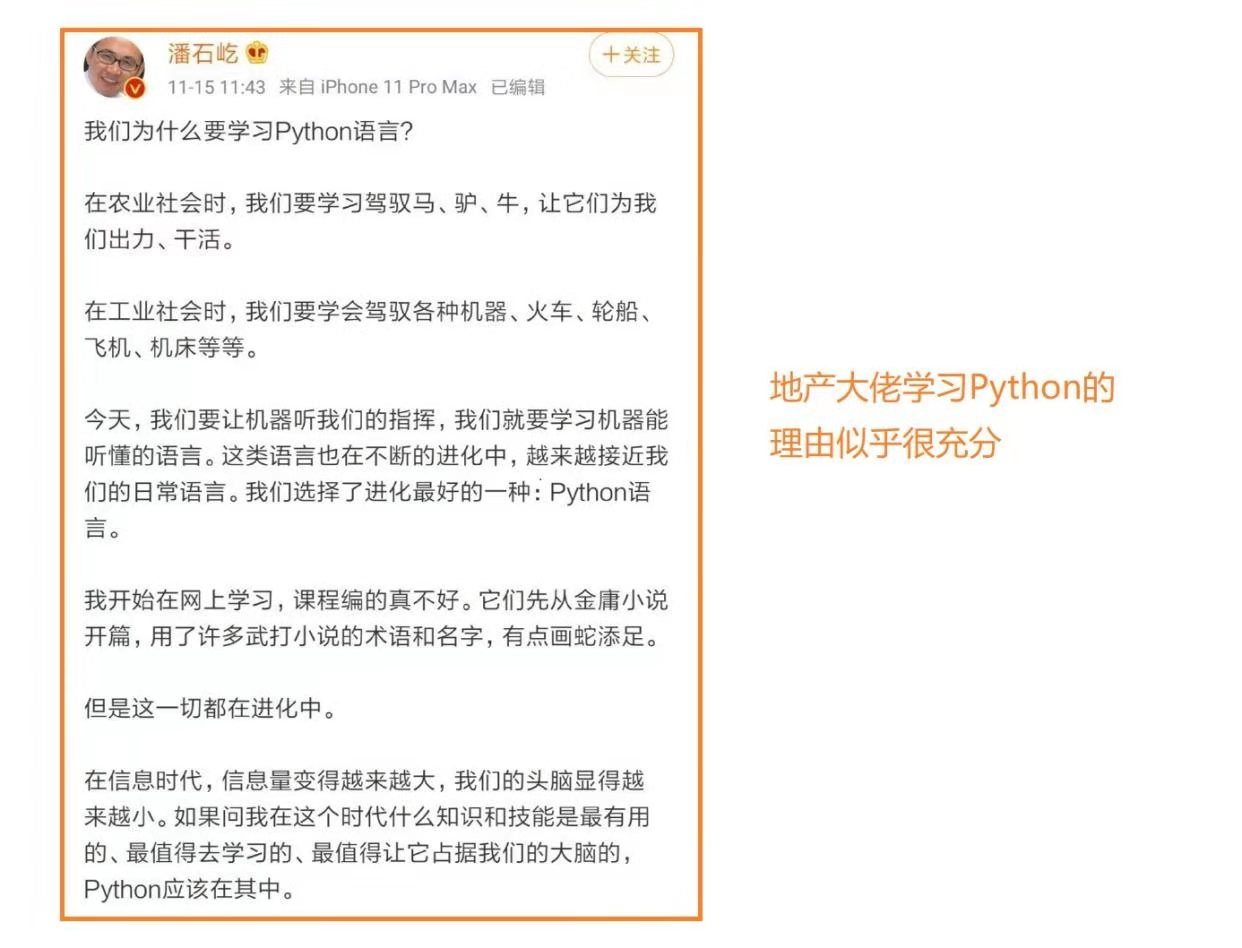

2019年11月16日，地产大佬潘石屹学python。

启示：只要方向是正确的，路就是直的。

今天，言言她幺爸幺妈过来给她过生日，女儿又大一岁了，祝福女儿生日快乐，想家！

此时的我在北大图书馆三楼继续等待代码运行完毕，希望选择的这条路是正确的！
加油，启红！


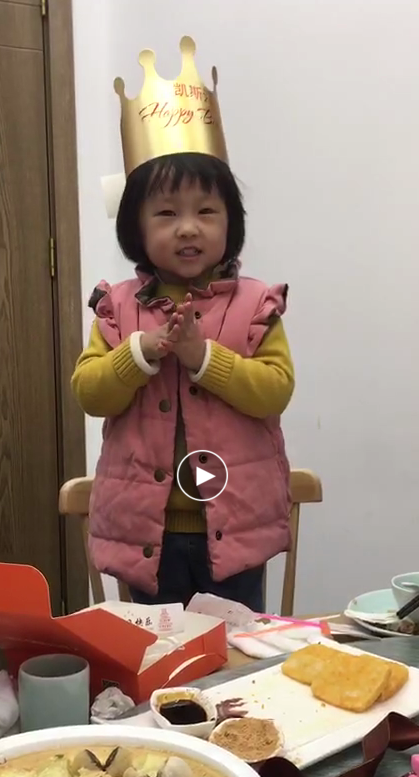
